In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
from skimage import io
%matplotlib inline

In [2]:
#Sample Image Read
image_path = 'Dataset/10253/0/10253_idx5_x1001_y1001_class0.png'
image = io.imread(image_path)

#Image shape
im_shape = np.shape(image)

In [3]:
#Calculates number of files in all subfolders 
num_files = sum([len(files) for r, d, files in os.walk('Dataset')]) 

In [4]:
#    ----    Load Data    ----


# num_files = 277524 #Run this line if number of files already computed to avoid recomputing

#Cap samples at given number to save memory
cap = 40000 #Cap number (if not using all data)

num_files = cap

#Pre-allocate image array for speed
all_images = np.zeros((num_files,im_shape[0],im_shape[1],im_shape[2]))
labels = np.zeros((num_files)) #Class labels

avoid_array = np.zeros((num_files)) #Makes note of images which were ignored (due to wrong size)

rootdir = 'Dataset/'
im_num = 0

for subdir, dirs, files in os.walk(rootdir):
    for ifile, file in enumerate(files):
        
        if im_num < cap:
            #Gets file path
            image_path = os.path.join(subdir, file)

            #Adds class label to lavels array
            labels[im_num] = int(image_path.split('.png')[0][-1])

            #Reads image and adds to images matrix
            image = io.imread(image_path)

            if np.shape(image) != (50,50,3):
                avoid_array[im_num] = 1
            else:
                #Scale image
                image = image / 255.0
                all_images[im_num] = image

            im_num += 1
        
#Remove avoid arrays
all_images = np.delete(all_images,np.nonzero(avoid_array),0)
labels = np.delete(labels,np.nonzero(avoid_array),0)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size = 0.2)

In [26]:
#Build initial model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=5)

#Save best model
mc = ModelCheckpoint('best_basic_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#Initialize model
model = Sequential()

# --- Layers ---
#1st Conv Layer
model.add(Conv2D(16, kernel_size=(3,3), activation ='relu', input_shape=im_shape))
model.add(MaxPool2D(pool_size=(2,2)))
# #2nd Conv Layer
# model.add(Conv2D(32, kernel_size=(3,3), activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# #3rd Conv Layer
# model.add(Conv2D(64, kernel_size=(3,3), activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
#Fully-connected
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#Activation Layer
model.add(Dense(1, activation='sigmoid'))


#Compile model 
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001),metrics=['accuracy'])

#Compile model 
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[es,mc])

Train on 31956 samples, validate on 7989 samples
Epoch 1/1000
31956/31956 [==============================] - 30s 929us/sample - loss: 0.3895 - accuracy: 0.8262 - val_loss: 0.3697 - val_accuracy: 0.8395
Epoch 2/1000
31956/31956 [==============================] - 29s 906us/sample - loss: 0.3574 - accuracy: 0.8436 - val_loss: 0.3343 - val_accuracy: 0.8510
Epoch 3/1000
31956/31956 [==============================] - 29s 907us/sample - loss: 0.3480 - accuracy: 0.8484 - val_loss: 0.3415 - val_accuracy: 0.8442
Epoch 4/1000
31956/31956 [==============================] - 30s 926us/sample - loss: 0.3400 - accuracy: 0.8529 - val_loss: 0.3269 - val_accuracy: 0.8562
Epoch 5/1000
31956/31956 [==============================] - 30s 926us/sample - loss: 0.3347 - accuracy: 0.8552 - val_loss: 0.3312 - val_accuracy: 0.8577
Epoch 6/1000
31956/31956 [==============================] - 29s 921us/sample - loss: 0.3320 - accuracy: 0.8569 - val_loss: 0.3525 - val_accuracy: 0.8420
Epoch 7/1000
31956/31956 [=======

In [27]:
from sklearn.metrics import classification_report

def score_model(model,X_test,y_test):

    #Test model accuracy
    test_loss, test_acc = model.evaluate(X_test,y_test)

    predictions = model.predict(X_test)
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0

    print(classification_report(y_test, predictions))
    
    return predictions

predictions = score_model(model,X_test,y_test)

7989/7989 [==============================] - 2s 300us/sample - loss: 0.3236 - accuracy: 0.8583
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      6149
         1.0       0.71      0.65      0.68      1840

    accuracy                           0.86      7989
   macro avg       0.80      0.78      0.79      7989
weighted avg       0.85      0.86      0.86      7989



In [28]:
from tensorflow.keras.models import load_model

# load the saved model
saved_model = load_model('best_basic_model.h5')

#Test Model Accuracy
saved_predictions = score_model(saved_model,X_test,y_test)

7989/7989 [==============================] - 2s 286us/sample - loss: 0.3229 - accuracy: 0.8596
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      6149
         1.0       0.72      0.64      0.68      1840

    accuracy                           0.86      7989
   macro avg       0.81      0.78      0.79      7989
weighted avg       0.85      0.86      0.86      7989



In [10]:
#Apply batch normalization to gauge effects on performance
from tensorflow.keras.layers import BatchNormalization

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=5)

#Initialize model
model_BN = Sequential()

# --- Layers ---
#1st Conv Layer
model_BN.add(Conv2D(16, kernel_size=(3,3), activation ='relu', input_shape=im_shape))
model_BN.add(BatchNormalization())
model_BN.add(MaxPool2D(pool_size=(2,2)))
#2nd Conv Layer
model_BN.add(Conv2D(32, kernel_size=(3,3), activation ='relu'))
model_BN.add(BatchNormalization())
model_BN.add(MaxPool2D(pool_size=(2,2)))
#3rd Conv Layer
model_BN.add(Conv2D(64, kernel_size=(3,3), activation ='relu'))
model_BN.add(BatchNormalization())
model_BN.add(MaxPool2D(pool_size=(2,2)))
#Fully-connected
model_BN.add(Flatten())
model_BN.add(Dense(256, activation='relu'))
#Activation Layer
model_BN.add(Dense(1, activation='sigmoid'))

#Compile model
model_BN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#Train model
model_BN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, callbacks=[es])

Train on 31956 samples, validate on 7989 samples
Epoch 1/8
31956/31956 [==============================] - 75s 2ms/sample - loss: 0.3426 - accuracy: 0.8544 - val_loss: 0.3442 - val_accuracy: 0.8437
Epoch 2/8
31956/31956 [==============================] - 74s 2ms/sample - loss: 0.3106 - accuracy: 0.8667 - val_loss: 1.3321 - val_accuracy: 0.3335
Epoch 3/8
31956/31956 [==============================] - 75s 2ms/sample - loss: 0.2951 - accuracy: 0.8720 - val_loss: 1.2887 - val_accuracy: 0.7699
Epoch 4/8
31956/31956 [==============================] - 74s 2ms/sample - loss: 0.2846 - accuracy: 0.8797 - val_loss: 0.3938 - val_accuracy: 0.8305
Epoch 5/8
31956/31956 [==============================] - 74s 2ms/sample - loss: 0.2726 - accuracy: 0.8828 - val_loss: 0.3505 - val_accuracy: 0.8407
Epoch 6/8
31956/31956 [==============================] - 75s 2ms/sample - loss: 0.2517 - accuracy: 0.8939 - val_loss: 1.2936 - val_accuracy: 0.5673


In [22]:
#Test Model Accuracy
BN_predictions = score_model(model_BN,X_test,y_test)

7989/7989 [==============================] - 3s 387us/sample - loss: 1.2936 - accuracy: 0.5673
              precision    recall  f1-score   support

         0.0       0.95      0.46      0.62      6149
         1.0       0.34      0.91      0.49      1840

    accuracy                           0.57      7989
   macro avg       0.64      0.69      0.56      7989
weighted avg       0.81      0.57      0.59      7989



In [33]:
# Model based on Dabeer et al., 2019 (Cancer diagnosis paper)

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=20)

#Save best model
mc = ModelCheckpoint('best_lit_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#Initialize model
model_lit = Sequential()

# --- Layers ---
#1st Conv Layer
model_lit.add(Conv2D(32, kernel_size=(5,5), activation ='relu', padding='same', input_shape=im_shape))
model_lit.add(MaxPool2D(pool_size=(3,3)))
#2nd Conv Layer
model_lit.add(Conv2D(64, kernel_size=(5,5), activation ='relu', padding='same', input_shape=im_shape))
model_lit.add(MaxPool2D(pool_size=(3,3)))
#3rd Conv Layer
model_lit.add(Conv2D(128, kernel_size=(5,5), activation ='relu', padding='same', input_shape=im_shape))
model_lit.add(MaxPool2D(pool_size=(3,3)))
#Fully-connected Layers
model_lit.add(Flatten())
model_lit.add(Dense(64, activation='relu'))
model_lit.add(Dense(64, activation='relu'))
#Activation Layer
model_lit.add(Dense(1, activation='sigmoid'))


#No loss function given in paper so using binary crossentropy
model_lit.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#Train model
model_lit.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[es,mc])

Train on 31956 samples, validate on 7989 samples
Epoch 1/1000
31956/31956 [==============================] - 89s 3ms/sample - loss: 0.3842 - accuracy: 0.8340 - val_loss: 0.3312 - val_accuracy: 0.8583
Epoch 2/1000
31956/31956 [==============================] - 89s 3ms/sample - loss: 0.3413 - accuracy: 0.8567 - val_loss: 0.3301 - val_accuracy: 0.8623
Epoch 3/1000
31956/31956 [==============================] - 89s 3ms/sample - loss: 0.3343 - accuracy: 0.8604 - val_loss: 0.3186 - val_accuracy: 0.8642
Epoch 4/1000
31956/31956 [==============================] - 88s 3ms/sample - loss: 0.3233 - accuracy: 0.8631 - val_loss: 0.3096 - val_accuracy: 0.8668
Epoch 5/1000
31956/31956 [==============================] - 89s 3ms/sample - loss: 0.3191 - accuracy: 0.8660 - val_loss: 0.3342 - val_accuracy: 0.8592
Epoch 6/1000
31956/31956 [==============================] - 89s 3ms/sample - loss: 0.3120 - accuracy: 0.8671 - val_loss: 0.3269 - val_accuracy: 0.8687
Epoch 7/1000
31956/31956 [===================

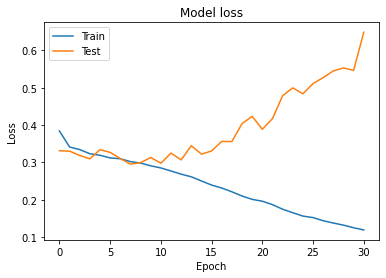

In [39]:
# Plot loss function over epochs
plt.plot(model_lit.history.history['loss'])
plt.plot(model_lit.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

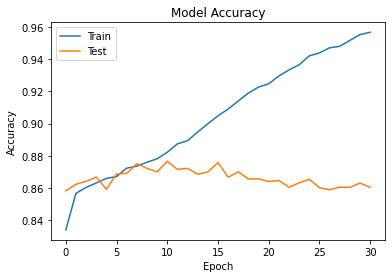

In [40]:
# Plot accuracy over epochs
plt.plot(model_lit.history.history['accuracy'])
plt.plot(model_lit.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [34]:
#Test Final Model Accuracy
lit_predictions = score_model(model_lit,X_test,y_test)

7989/7989 [==============================] - 6s 725us/sample - loss: 0.6484 - accuracy: 0.8604
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      6149
         1.0       0.73      0.63      0.68      1840

    accuracy                           0.86      7989
   macro avg       0.81      0.78      0.79      7989
weighted avg       0.86      0.86      0.86      7989



In [35]:
#Test best lit model - this comes from epoch 11 and therefore was fit prior to the overfitting that followed after

# load the saved model
saved_lit_model = load_model('best_lit_model.h5')

#Test Model Accuracy
saved_lit_predictions = score_model(saved_lit_model,X_test,y_test)

7989/7989 [==============================] - 6s 726us/sample - loss: 0.2979 - accuracy: 0.8766
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      6149
         1.0       0.78      0.64      0.71      1840

    accuracy                           0.88      7989
   macro avg       0.84      0.79      0.81      7989
weighted avg       0.87      0.88      0.87      7989

